# Line Object

I create a Line object to:
1. keep track of previous lane pixels
2. Search lane pixels on a binary warped image
3. Calculate curvature and the offset of vehicle

### 1. Search Lane pixels from scratch

To search lane pixels from scratch, we use a sliding window method. We basically find two prominent peaks from a histogram within each sliding window and use those peak as the location of the left and right lane.

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [93]:
"""
Draw a polynomial line on an image
"""
def draw_polyline(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255,255,0), thickness=3)
    return img

In [94]:
"""
Sliding window search method. It's used to locate lane pixels from scratch, given no previous information.
Input: a binary image with birds' eye view.
Ouput: left and right fitted x,y and a diagnosis image.
"""
def sliding_win_search(binary_warped, nwindows=9, margin=100, minpix=50):
    # A diagnosis image
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Get the histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(diag_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(diag_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Highlight lane pixels and draw fit polynomials
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    
    return left_fit, right_fit, diag_img

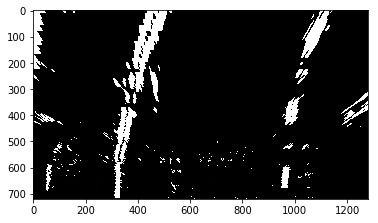

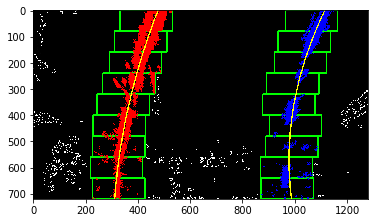

In [96]:
img = mpimg.imread('warped.jpg')
plt.imshow(img, cmap='gray')
plt.show()

left_fit, right_fit, diag_img = sliding_win_search(img)
plt.imshow(diag_img)
plt.show()

### 2. Polynomial ROI search

If we keep track of the location of previous lane line, we can search around those lane lines. 

In [97]:
"""
Draw search region (Region of Interest) on an image
"""
def draw_roi(img, fit, margin):
    window_img = np.zeros_like(img)
    
    # Generate x and y values for plotting
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    
    line_window1 = np.array([np.transpose(np.vstack([x-margin, y]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([x+margin, y])))])
    line_pts = np.hstack((line_window1, line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
    return result

In [98]:
"""
Search lane pixels within a polynomial ROI given the previous left and right lane polynomial function.
Input: a binary image from birds' eye view, left lane and right lane polynomial function.
Output: fitted left/right lane lines, a diagnosis image.
"""
def search_roi(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_center = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > (left_center - margin)) & (nonzerox < (left_center + margin))) 
    right_center = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_center - margin)) & (nonzerox < (right_center + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #------------- VISUALIZE THE OUTPUT ------------------

    # Create an image to draw on and an image to show the selection window
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Illustrate the search window area
    diag_img = draw_roi(diag_img, left_fit, margin)
    diag_img = draw_roi(diag_img, right_fit, margin)
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    return left_fit, right_fit, diag_img

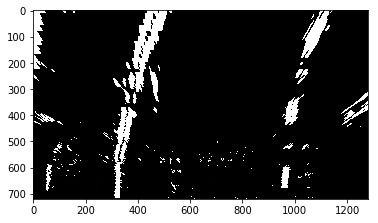

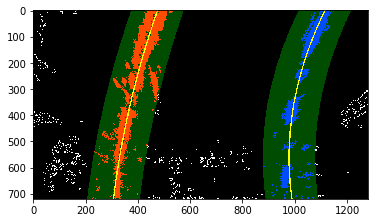

In [99]:
img = mpimg.imread('warped.jpg')
plt.imshow(img, cmap='gray')
plt.show()

left_fit, right_fit, diag_img = search_roi(img, left_fit, right_fit)
plt.imshow(diag_img)
plt.show()

### 3. Curvature and Offset

Calculate the curvature and offset given a binary warped image

In [100]:
# Global variable
ym_per_pix = 30/720
xm_per_pix = 3.7/1100

In [101]:
"""
Calculate curvature in meter.
Input: height of an image; a second order polynomial function.
Output: curvature in meter.
"""
def cal_curvature(img_h, fit):
    y = np.linspace(0, img_h-1, img_h)
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    y_eval = y[-1]
    
    # fit x,y in real world
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

"""
Calculate the curvature in unit of meter.
Input: left lane and right lane polynomial function; an evaluation position
Output: left, right and average curvature.
"""
def cal_lane_curv(img_h, left_fit, right_fit):
    avg_fit = np.mean([left_fit, right_fit], axis = 0)
    
    left_curvature = cal_curvature(img_h, left_fit)
    right_curvature = cal_curvature(img_h, right_fit)
    radius_of_curvature = cal_curvature(img_h, avg_fit)
    
    return left_curvature, right_curvature, radius_of_curvature

In [102]:
"""
Calculate the offset of the car. Assume the camera locates at the middle of the car.
"""
def cal_offset(img_h, img_w, left_fit, right_fit):
    y_eval = img_h - 1;
    left_x = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    right_x = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
    
    # left x and right x
    car_center = (left_x + right_x)/2
    lane_center = img_w / 2
    offset = np.abs(car_center - lane_center)
    return offset * xm_per_pix

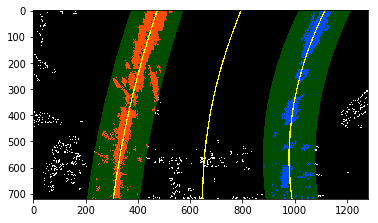

[  1.44392995e-04  -3.37576029e-01   4.75226571e+02] [  4.35268430e-04  -4.89070866e-01   1.11594098e+03]
left curv: 1787.57401104
right curv: 593.008351272
curv: 890.418404071
offset: 0.027700869683


In [103]:
img = mpimg.imread('warped.jpg')
#left_fit, right_fit, diag_img = sliding_win_search(img)
left_fit, right_fit, diag_img = search_roi(img, left_fit, right_fit)
avg_fit = np.mean([left_fit, right_fit], axis = 0)
diag_img = draw_polyline(diag_img, avg_fit)
plt.imshow(diag_img)
plt.show()

left_curvature, right_curvature, radius_of_curvature = cal_lane_curv(img.shape[0], left_fit, right_fit)
print(left_fit, right_fit)
offset = cal_offset(img.shape[0], img.shape[1], left_fit, right_fit)
print("left curv:", left_curvature)
print("right curv:", right_curvature)
print("curv:", radius_of_curvature)
print("offset:", offset)

### 4. Line object

In [104]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 8 # Number of iterations that's to be averaged
        
        self.img_w = None
        self.img_h = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.curr_left_fit = [] 
        self.curr_right_fit = [] 
                                
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None 
         
        #radius of curvature of the line in some units
        self.left_curvature = None
        self.right_curvature = None
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    """
    Sanity check on new found lines.
    Input: left and right lane.
    Output: True or False means pass or not.
    """
    def sanity_check(self, left_fit, right_fit):
        ploty = np.linspace(0, self.img_h-1, self.img_h)
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        # 1. Check if they have similar curvature
        curv_dev = 8 # variance, 5 times
        left_curverad = cal_curvature(self.img_h, left_fit)
        right_curverad = cal_curvature(self.img_h, right_fit)
        
        ratio = left_curverad / right_curverad 
        if ((ratio >= curv_dev) | (ratio <= 1./curv_dev)):
            return False
        #print("ratio", ratio)
        
        # 2. Check lines are seperated by right distance
        dist_dev = 100
        valid_dist = 700 # Lane line pixel is about 700 wide, stay tuned
        curr_dist = right_fitx[-1] - left_fitx[-1]
        if (np.abs(curr_dist - valid_dist) > dist_dev):
            return False
        #print("curr dist", curr_dist)
        
        # 3. Check if lines are roughly paralell
        lines_dev = 80
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        #print("std dev", dev)
        if (dev >= lines_dev):
            return False
            
        return True
        
    """
    Find lane pixels given a binary warped image.
    Input: a binary image from birds' eye view.
    Output: left and right lane in polynomial function and a diagnosis image
    """
    def find_lane(self, binary_warped):
        self.img_w = binary_warped.shape[1]
        self.img_h = binary_warped.shape[0]
        
        if (self.detected):
            last_left_fit = self.curr_left_fit[-1]
            last_right_fit = self.curr_right_fit[-1]
            left_fit, right_fit, diag_img = search_roi(binary_warped, last_left_fit, last_right_fit)
        else:
            left_fit, right_fit, diag_img = sliding_win_search(binary_warped)
        
        if (self.sanity_check(left_fit, right_fit)):
            # pass
            self.detected = True
        else:
            # not pass
            self.detected = False
            # use the last one as current fit
            left_fit = self.curr_left_fit[-1]
            right_fit = self.curr_right_fit[-1]
        
        self.curr_left_fit.append(left_fit)
        self.curr_right_fit.append(right_fit)
        
        # Only keep last n iterations
        if (len(self.curr_left_fit) > self.n):
            self.curr_left_fit = self.curr_left_fit[-self.n:]
            self.curr_right_fit = self.curr_right_fit[-self.n:]
        
        # average
        self.best_left_fit = np.mean(self.curr_left_fit, axis=0)
        self.best_right_fit = np.mean(self.curr_right_fit, axis=0)
        
        # Calculate curvature and offset
        self.left_curvature, self.right_curvature, self.radius_of_curvature = cal_lane_curv(self.img_h, left_fit, right_fit)
        self.line_base_pos = cal_offset(self.img_h, self.img_w, left_fit, right_fit)
        
        return diag_img
    
    def get_lane(self):
        return self.best_left_fit, self.best_right_fit
    
    def get_curvature(self):
        return self.left_curvature, self.right_curvature, self.radius_of_curvature
    
    def get_offset(self):
        return self.line_base_pos

Now Test on an image. The first time we invoke find_lane function on a line object, it should use the sliding window search algorithm to find lane pixels.

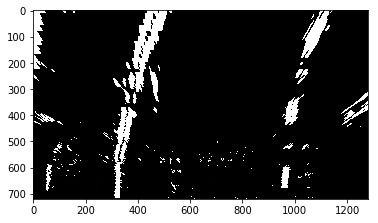

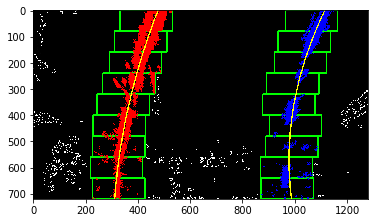

[  2.23090058e-04  -3.90812851e-01   4.78139852e+02] [  4.19709859e-04  -4.79568379e-01   1.11522544e+03]
1156.85538428 614.970887981 802.963410692
0.0334070966747


In [105]:
img = mpimg.imread('warped.jpg')
plt.imshow(img, cmap='gray')
plt.show()
line = Line()

diag_img = line.find_lane(img)
left_fit, right_fit = line.get_lane()
left_curv, right_curv, curv = line.get_curvature()
offset = line.get_offset()

plt.imshow(diag_img)
plt.show()
print(left_fit, right_fit)
print(left_curv, right_curv, curv)
print(offset)

The second time we invoke the find_lane method, it should use the ROI search algorithm to find lane pixels:

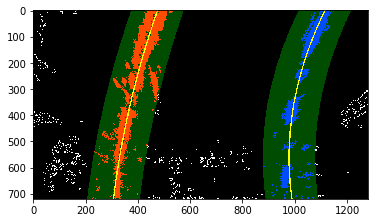

[  1.90072378e-04  -3.68911952e-01   4.77026393e+02] [  4.27187657e-04  -4.84182889e-01   1.11557456e+03]
1643.42495872 593.830042167 872.272859526
0.0282319650752


In [106]:
diag_img = line.find_lane(img)
left_fit, right_fit = line.get_lane()
left_curv, right_curv, curv = line.get_curvature()
offset = line.get_offset()

plt.imshow(diag_img)
plt.show()
print(left_fit, right_fit)
print(left_curv, right_curv, curv)
print(offset)